In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchmetrics import AUROC
import torch.nn.functional as F

from func2graph.data import data_simulator, generate_simulation_data
from func2graph import models, tools, baselines

### Construct Data

In [9]:
neuron_num = 200   #####################
dt = 0.05
tau = 10

spike_neuron_num=2
spike_input=5

init_scale = 0.1  #################
weight_scale = 0.1   #################
error_scale = 1  #################

total_time = 30000

data_random_seed=42 ######################

weight_type="cell_type"

test = False  ######################

simulator = data_simulator(
    neuron_num=neuron_num, 
    dt=dt, 
    tau=tau, 
    spike_neuron_num=spike_neuron_num, 
    spike_input=spike_input,
    weight_scale= weight_scale,
    init_scale=init_scale,
    error_scale=error_scale,
    total_time=total_time,
    data_random_seed=data_random_seed,
    weight_type=weight_type,
    test=test,
)

if test == False:
    result = []

    for t in range(total_time):
        x_t = simulator.forward(t)
        x_t = x_t.view(-1, 1)
        result.append(x_t)

    result = np.concatenate(result, axis=1)

    print(result.shape)

else:
    signal_result = []
    error_result = []

    for t in range(total_time):
        signal, error = simulator.forward(t)
        signal = signal.view(-1, 1)
        error = error.view(-1, 1)
        signal_result.append(signal)
        error_result.append(error)

    signal_result = np.concatenate(signal_result, axis=1)
    error_result = np.concatenate(error_result, axis=1)

    print(signal_result.shape)
    print(error_result.shape)

(200, 30000)


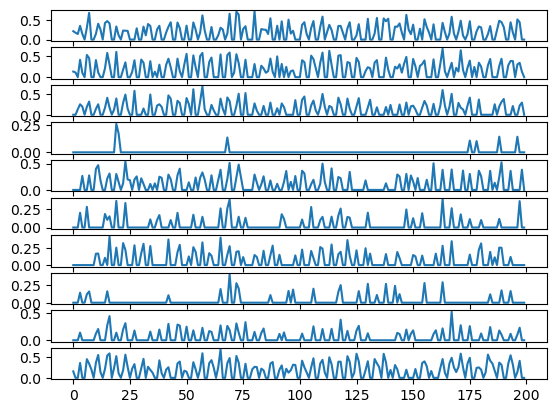

In [79]:
# make signal data below 0 to 0
modified_signal_result = np.where(signal_result < 0.1, 0, signal_result)

for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.plot(modified_signal_result[i,:200])
plt.show()

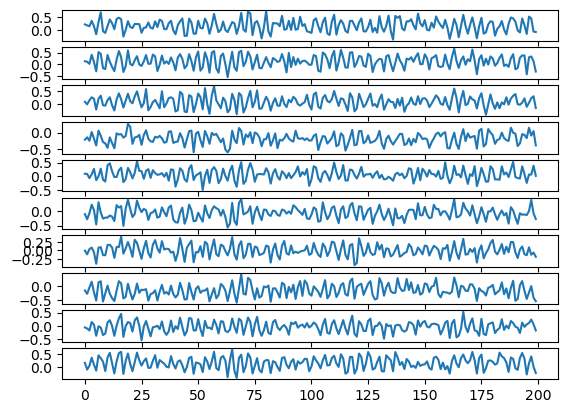

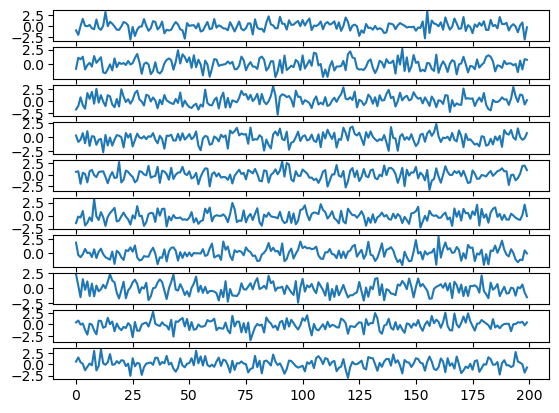

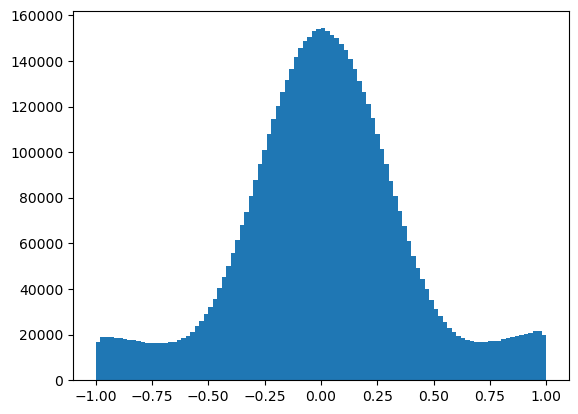

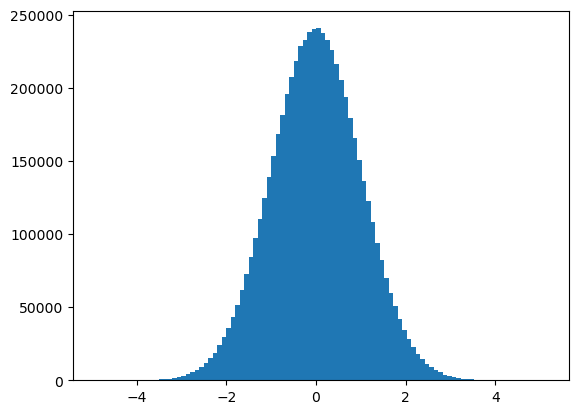

In [6]:
for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.plot(signal_result[i,:200])
plt.show()

for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.plot(error_result[i,:200] + signal_result[i,:200])
plt.show()

plt.hist(signal_result.flatten(), bins=100)
plt.show()
plt.hist(error_result.flatten(), bins=100)
plt.show()

(200, 200)
-0.0720380247280713


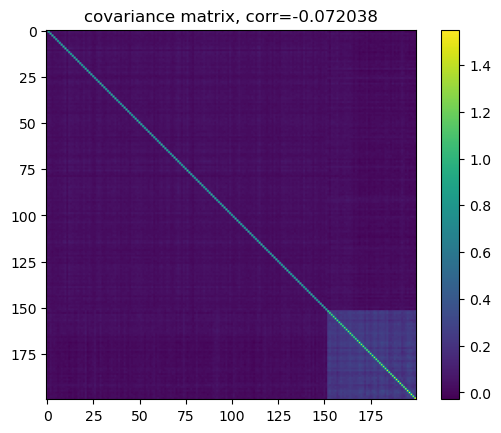

In [10]:
# calculate covariance matrix using activity
weight_matrix = simulator.W_ij

cov = np.cov(result)
print(cov.shape)
corr = np.corrcoef(cov.flatten(), weight_matrix.detach().numpy().flatten())[0, 1]
print(corr)

plt.imshow(cov)
plt.title("covariance matrix, corr={:.6f}".format(corr))
plt.colorbar()
plt.show()

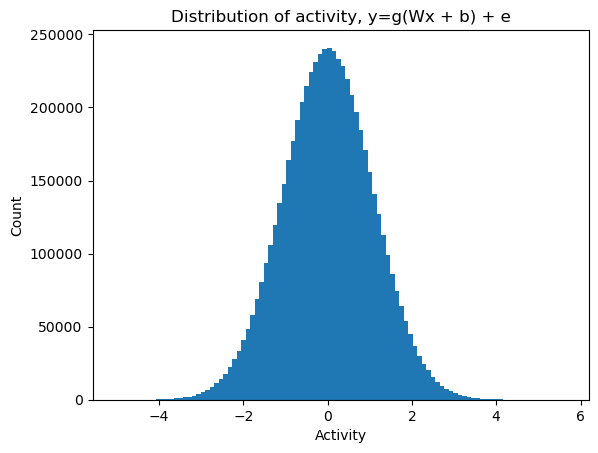

In [11]:
# plot distribution of activity
plt.hist(result.flatten(), bins=100)
plt.title("Distribution of activity, y=g(Wx + b) + e")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.show()

In [21]:
# get the largest value of activity
max_activity = np.max(result)
print("max activity: ", max_activity)
min_activity = np.min(result)
print("min activity: ", min_activity)
medium_activity = np.median(result)
print("medium activity: ", medium_activity)

max activity:  5.829624
min activity:  -5.8583865
medium activity:  0.0139166415


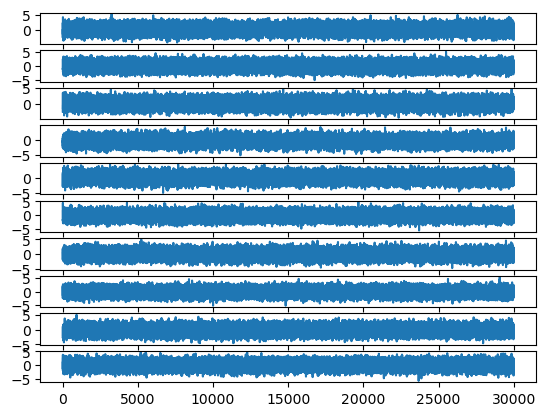

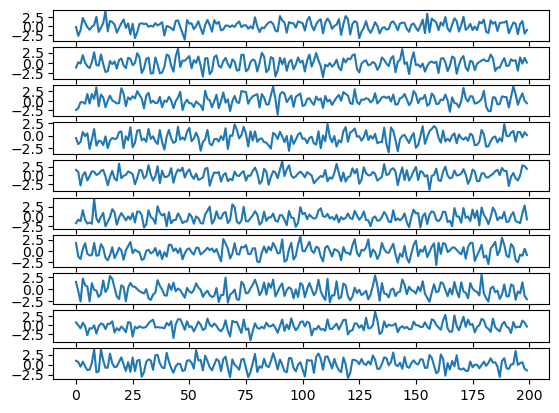

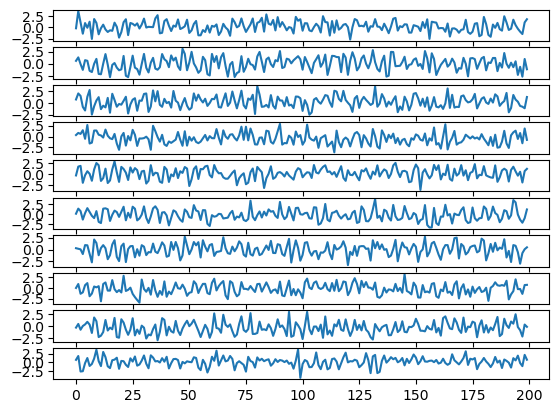

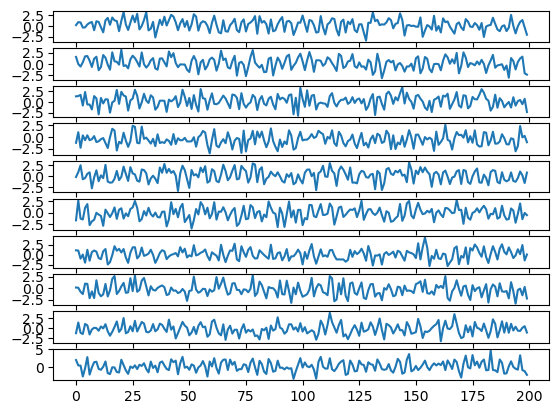

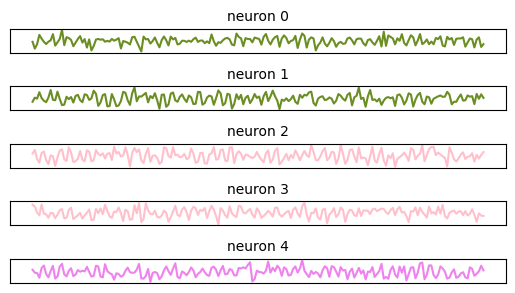

In [22]:
neuron_num = 10
for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][:200])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][400:600])
plt.show()

for i in range(neuron_num):
    plt.subplot(10, 1, i+1)
    plt.plot(result[i][5000:5200])
plt.show()



ax1 = plt.subplot(13, 1, 1)
ax1.set_title("neuron 0", fontsize=10)
ax1.plot(result[0][:200], c='olivedrab')
# remove xticks
plt.xticks([])
plt.yticks([])

ax2 = plt.subplot(13, 1, 3)
ax2.set_title("neuron 1", fontsize=10)
ax2.plot(result[1][:200], c='olivedrab')
plt.xticks([])
plt.yticks([])

ax3 = plt.subplot(13, 1, 5)
plt.title("neuron 2", fontsize=10)
plt.plot(result[152][:200], c='pink')
plt.xticks([])
plt.yticks([])

plt.subplot(13, 1, 7)
plt.title("neuron 3", fontsize=10)
plt.plot(result[153][:200], c='pink')
plt.xticks([])
plt.yticks([])

plt.subplot(13, 1, 9)
plt.title("neuron 4", fontsize=10)
plt.plot(result[160][:200], c='violet')
plt.xticks([])
plt.yticks([])
plt.show()


rank of the weight matrix:  200


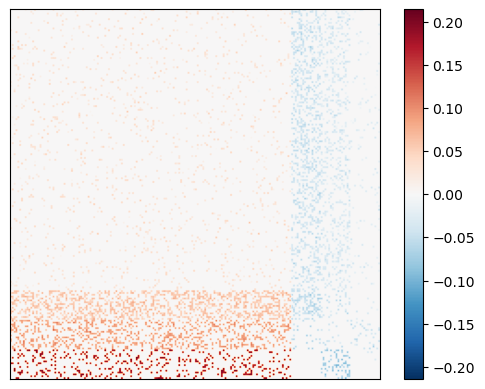

In [7]:
weight_matrix = simulator.W_ij

# compute the rank of the weight matrix
rank = np.linalg.matrix_rank(weight_matrix.detach().numpy())
print("rank of the weight matrix: ", rank)

# choose the larger abs of min and max
max_abs = np.max(np.abs(weight_matrix.detach().numpy()))
plt.imshow(weight_matrix.detach().numpy(), cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

torch.Size([200, 30000])
val_data.shape:  torch.Size([5801, 200, 200])
tensor([[-1.6911,  0.6748,  1.8291,  ...,  0.0242,  0.8528,  2.4147],
        [-1.2896,  1.0702, -0.8654,  ...,  1.6516,  2.1274, -1.5712],
        [-2.0636,  0.4282,  1.8470,  ...,  1.4348, -0.8813, -0.7332],
        ...,
        [-0.2945, -0.9614,  1.7570,  ..., -0.5612,  3.4060,  1.0130],
        [-0.5361, -0.8114,  2.7472,  ..., -0.8744,  0.4353,  1.4764],
        [-0.3347,  0.2065, -1.1262,  ..., -2.0218,  1.5395,  1.5110]])


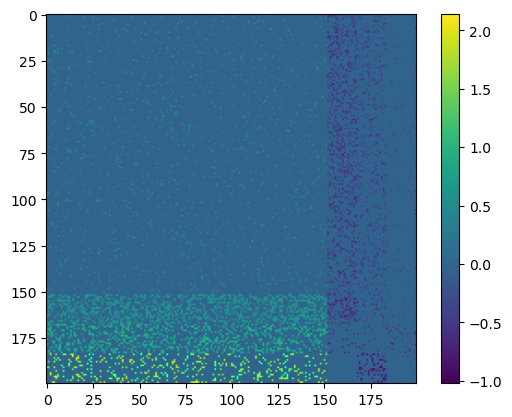

In [31]:
neuron_num = 200
dt = 0.001
tau = 0.3

spike_neuron_num=2
spike_input=20

random_seed=42
total_time = 30000

weight_type = "cell_type"

trainloader, validloader, weight_matrix, cell_type_ids, cell_type2id, cell_type_count = generate_simulation_data(
    neuron_num=neuron_num, 
    dt=dt, 
    tau=tau, 
    spike_neuron_num=spike_neuron_num, 
    spike_input=spike_input,
    data_random_seed=random_seed,
    total_time=total_time,
    weight_type=weight_type,
)

plt.imshow(weight_matrix.detach().numpy())
plt.colorbar()
plt.show()

torch.Size([32, 200, 200])


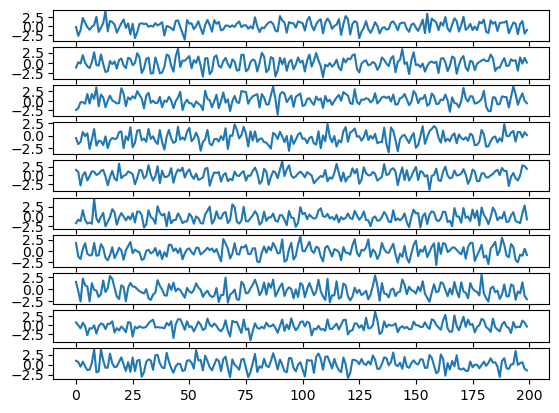

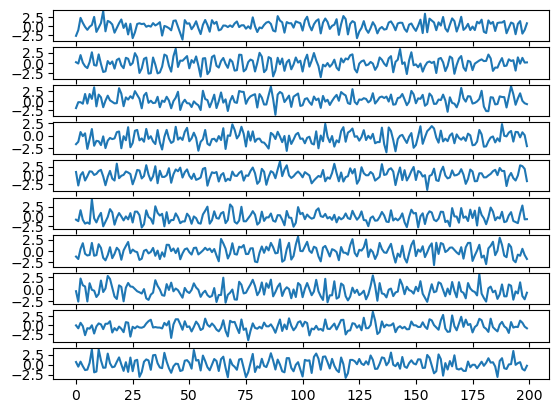

In [12]:
for i_batch, sample_batched in enumerate(trainloader):
    print(sample_batched[0].shape)
    samples = sample_batched[0][0:2]
    for i in range(10):
        plt.subplot(10, 1, i+1)
        plt.plot(samples[0][i])
    plt.show()
    for i in range(10):
        plt.subplot(10, 1, i+1)
        plt.plot(samples[1][i])
    plt.show()
    break

### Correlation Matrix

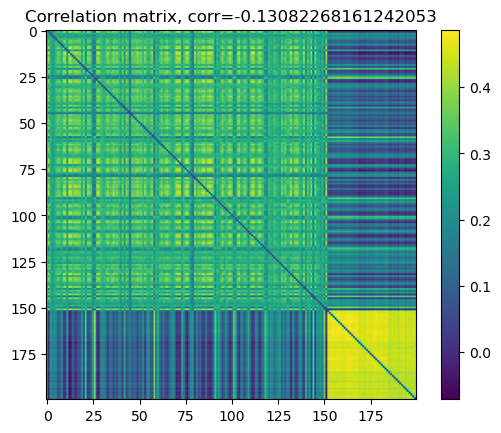

In [10]:
corr_matrix = baselines.get_activity_correlation_matrix(activity=result)
corr = np.corrcoef(corr_matrix.flatten(), weight_matrix.detach().numpy().flatten())[0, 1]

plt.imshow(corr_matrix)
plt.title("Correlation matrix, corr=" + str(corr))
plt.colorbar()
plt.show()

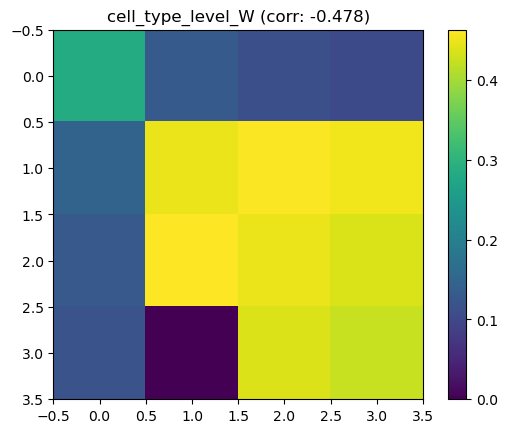

In [33]:
cell_type_id2cell_type = {0:'EC', 1:'Pv', 2:'Sst', 3:'Vip'}

weight_matrix = weight_matrix.detach().numpy()
cell_type_level_W = tools.calculate_cell_type_level_connectivity_matrix_remove_no_connection(
    connectivity_matrix_new=corr_matrix,
    connectivity_matrix_GT=weight_matrix, 
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)

strength_matrix = np.zeros((4, 4))
strength_matrix[0, 0] = 0.3
strength_matrix[1, 0] = 0.59
strength_matrix[2, 0] = 0.88
strength_matrix[3, 0] = 1.89

strength_matrix[0, 1] = -0.43
strength_matrix[1, 1] = -0.53
strength_matrix[2, 1] = -0.60
strength_matrix[3, 1] = -0.44

strength_matrix[0, 2] = -0.31
strength_matrix[1, 2] = -0.43
strength_matrix[2, 2] = -0.43
strength_matrix[3, 2] = -0.79

strength_matrix[0, 3] = -0.25
strength_matrix[1, 3] = -0.30
strength_matrix[2, 3] = -0.42
strength_matrix[3, 3] = -0.33

cell_type_corr = np.corrcoef(cell_type_level_W.flatten(), strength_matrix.flatten())[0, 1]
plt.imshow(cell_type_level_W)
plt.colorbar()
plt.title("cell_type_level_W" + " (corr: " + str(cell_type_corr)[:6] + ")")
plt.show()

In [35]:
# make all nonzero elements in GT weight matrix to 1
binary_GT = np.zeros(weight_matrix.shape)
binary_GT[weight_matrix != 0] = 1

# min max normalization
prob_W = np.abs(corr_matrix)
prob_W = (prob_W - np.min(prob_W)) / (np.max(prob_W) - np.min(prob_W))

# prob_W = np.abs(corr_matrix)

cross_entropy = F.binary_cross_entropy(torch.from_numpy(prob_W).float().view(-1), torch.from_numpy(binary_GT).float().view(-1))
auroc = AUROC(task="binary")
auroc_val = auroc(torch.from_numpy(prob_W).float().view(-1), torch.from_numpy(binary_GT).float().view(-1))

print("cross entropy: ", cross_entropy)
print("AUROC: ", auroc_val)

cross entropy:  tensor(0.9857)
AUROC:  tensor(0.3501)


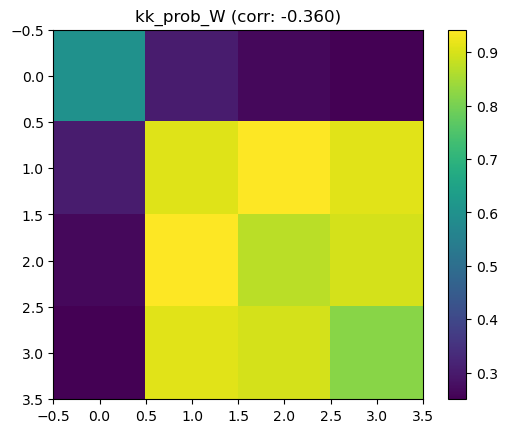

In [36]:
kk_prob_W = tools.calculate_cell_type_level_connectivity_matrix(
    connectivity_matrix_new=prob_W,
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)

cutoff_matrix = np.zeros((4, 4))
cutoff_matrix[0, 0] = 13/229
cutoff_matrix[1, 0] = 22/53
cutoff_matrix[2, 0] = 20/67
cutoff_matrix[3, 0] = 11/68

cutoff_matrix[0, 1] = 18/52
cutoff_matrix[1, 1] = 45/114
cutoff_matrix[2, 1] = 8/88
cutoff_matrix[3, 1] = 0/54

cutoff_matrix[0, 2] = 13/56
cutoff_matrix[1, 2] = 15/84
cutoff_matrix[2, 2] = 8/154
cutoff_matrix[3, 2] = 25/84

cutoff_matrix[0, 3] = 3/62
cutoff_matrix[1, 3] = 1/54
cutoff_matrix[2, 3] = 12/87
cutoff_matrix[3, 3] = 2/209

corr = np.corrcoef(kk_prob_W.flatten(), cutoff_matrix.flatten())[0, 1]
plt.imshow(kk_prob_W)
plt.colorbar()
plt.title("kk_prob_W" + " (corr: " + str(corr)[:6] + ")")
plt.show()